# Goal

The goal of this notebook is to better understand how G-Research calculates the Target from the actual asset prices. This understanding is vital to build a model that predicts the G-Research Target as opposed to a model that simply predicts asset prices. However in the process of trying to replicate the Target value. I have found some inconsistancies between the methodology from the tutorial [Tutorial to the G-Research Crypto Competition](https://www.kaggle.com/alexfir/recreating-target/notebook?scriptVersionId=80084997&cellId=1) and the methodoly that is actually used by G-Research in the training data. Becuase of these inconsistancies, the Targets that we were given do not represent the true asset specific return. Please see my findings and notebook below.

I also want to thank everyone contributed to the discussion board regarding this topic [Recreating Target](https://www.kaggle.com/alexfir/recreating-target/comments). I got lots of insights from there.
And also, my notebook is based on another notebook [Recreating Target](https://www.kaggle.com/alexfir/recreating-target/notebook).

# Inconsistency Findings

Note: In this notebook, I will refer to [Tutorial to the G-Research Crypto Competition](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition) as ***G-Research Tutorial***. All the efforts to recreate the Target in the training data has allowed us to infer how G-Research actualy calculates the target (it's not the same as the G-Research Tutorial). I will refer to the methodoloy G-Research uses to calculate the Target in the traning data as the ***Target-Methodology***.

1. ***Padding for Missing Data(rows)***:
Padding for missing rows is a best practcie when handling time series, especially for this competition where we are trying to calculate market-returns over the next 15 mins. In G-Research Tutorial missing rows are padded with previous available rows :eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='**pad**'). However, the target provided in the training data seems to be calculated using NaN for padding. 

2. ***Beta = 0***:
As a result from padding with NaN (mentioned in above finding), the *Target-Methodology* calculates beta=0 if either the next minute or the next 16th minute is missing (NaN). This is a pretty unrealistic way to calculate beta in my opinion. Beta is supposed to represent a type of correlation between a given asset and the market. Missing data or simply no trade during a period, doesn't mean the correlation with market is 0 for that period. If we set beta=0 for these periods, the beta time sereis will not be smooth. Please see plot below for Asset_ID = 5.
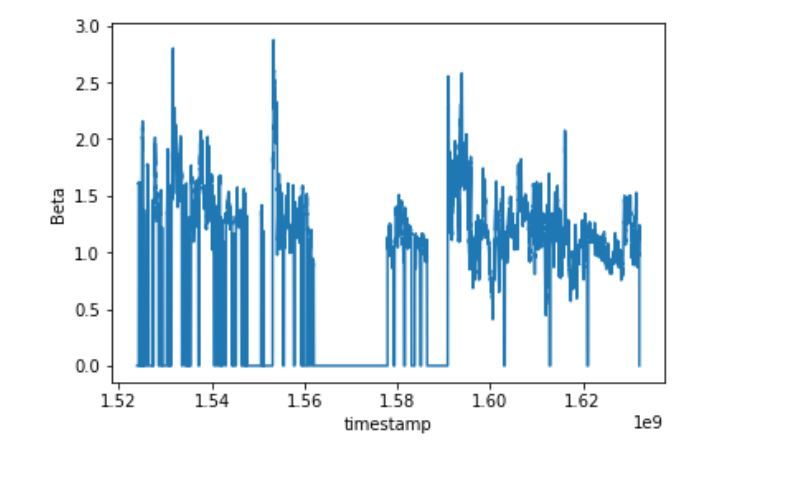

I think a better way to handle this is to follow the G-Research Tutorial, where we pad missing rows with previous avaible rows. In that case, stock price will be smooth and beta will be less noisy without the random discontious jumps to 0. The *Target-Methodology* approach to calculate beta will not result in an accurate measure of asset specific return.

3. ***Market-Return Calculation Not Ideal***:
Based on G-Research Tutorial, market-return is calculated as follows: $$M(t) = \frac{\sum_a w^a R^a(t)}{\sum_a w^a}$$ 
R^a refers to log-return for an asset, which is calculated as follows: $$R^a(t) = log (P^a(t+16)\ /\ P^a(t+1))$$ 
Let's look at this following case. Assume real world log-returns are constant from time-2 to time-4 for Asset1, Asset2 and Asset3. Simply assume beta = 1 and all three assests are equally weighted. However, in training data, log-return for Asset2 at time-3 is missing. If we follow G-Research Tutorial's approach to pad missing rows, there will not be any missing prices (no NaN log-returns), target should look like below:
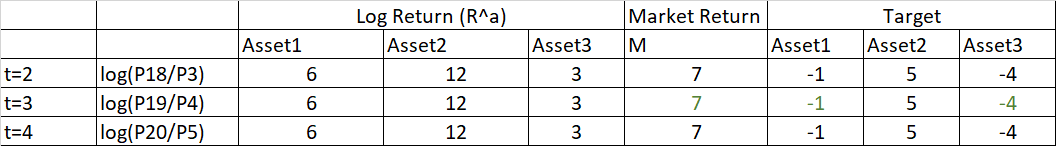

Lets take a look at the same case but with the *Target-Methodology*. We will have a NaN log-return for Asset2 at time=3.
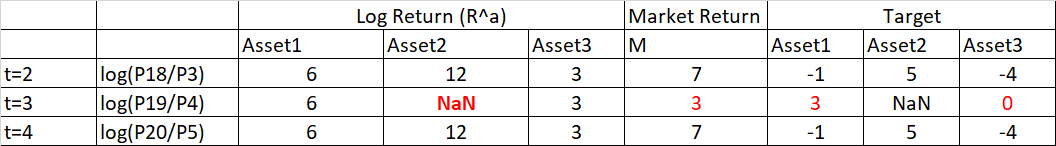

As you can see, becuase of the NaN for Asset2, market-return has changed significantly. This is because in the *Target-Methodology*, the market-return treats NaN as 0 and averages over all assets (instead of averaging over only the non NaN assets). This approach is strange because a NaN log-return in Asset2 results in Asset1's and Asset3's target value to swing unpredictably. 

# Summary

Based on what we have inferred about the *Target-Methodology*, both the beta and market-return have random jumps based on whether or not there is missing price data in the future(15 mins period future). If the scoring process calculates the Target using the *Target-Methodology*, in order for our models to correctly predict the Target, our models needs to predict whether or not there will be missing data for each asset in the future. It is unlikely that there is any pattern in when missing data occurs. Predicting missing data may not be impossible but seems very difficult to do using the features in the training data. 
 
To summarize,the *Target-Methodology* G-Research uses makes training a high-scoring model difficult. Moreover, the prediction from this model might match the (strangely calculated) Target but won't match the actual returns from the crypto market. All of above problems can be simply solved if the Target we are trying to predict calculated based on G-Research Tutorial (padding missing data with previous available row instead of padding with NaN).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as math

data = pd.read_csv(r"../input/g-research-crypto-forecasting/train.csv")
asset_details = pd.read_csv(r"../input/g-research-crypto-forecasting/asset_details.csv")

asset_df_Dict = {}
Asset_IDs = asset_details.Asset_ID.to_numpy()
asset_details['Normalized_Weight'] = asset_details['Weight'] / asset_details['Weight'].sum()

all_timestamps = np.sort(data['timestamp'].unique())
##insert January 1, 2018 12:00:00 to all_timestamps to better match the target.
all_timestamps = np.insert(all_timestamps, 0, 1514764800, axis=0)

In [ ]:
for i in Asset_IDs:
    data_asset_i = data[data['Asset_ID']==i].copy()

    ##calculate Return for each timestamp
    data_asset_i.sort_values(by = 'timestamp', inplace = True)
    data_asset_i.set_index('timestamp', inplace = True)
    
    data_asset_i = data_asset_i.reindex(all_timestamps)
    
    data_asset_i['P1'] = data_asset_i.shift(periods=-1)['Close']
    data_asset_i['P16'] = data_asset_i.shift(periods=-16)['Close']
    data_asset_i['Log_Return'] = (data_asset_i['P16']/data_asset_i['P1'])-1
    
    weight_i = asset_details[asset_details['Asset_ID']==i]['Normalized_Weight'].iloc[0]
    data_asset_i['Weighted_Log_Return'] = (data_asset_i['Log_Return']) * weight_i
    asset_df_Dict[i] = data_asset_i

In [ ]:
market_return = asset_df_Dict[Asset_IDs[0]]['Weighted_Log_Return']

for i in Asset_IDs[1:]:
    market_return = market_return.add(asset_df_Dict[i]['Weighted_Log_Return'], fill_value = 0)

for i in Asset_IDs:
    asset_df_Dict[i]['Market_Return'] = market_return
    
    num = pd.DataFrame(asset_df_Dict[i]['Log_Return'] * asset_df_Dict[i]['Market_Return']).rolling(3750).mean().values  #numerator of linear regression coefficient
    denom = pd.DataFrame(asset_df_Dict[i]['Market_Return']*asset_df_Dict[i]['Market_Return']).rolling(3750).mean().values  #denominator of linear regression coefficient
    beta = np.nan_to_num( num / denom, nan=0., posinf=0., neginf=0.)  #if regression fell over, use beta of 0
    asset_df_Dict[i]['Beta'] = beta
    asset_df_Dict[i]['Re_Calc_Target'] = asset_df_Dict[i]['Log_Return'] - (asset_df_Dict[i]['Beta'] * asset_df_Dict[i]['Market_Return'])
    
    original_timestamp= np.sort(data[data['Asset_ID']==i].timestamp.unique())
    asset_df_Dict[i] = asset_df_Dict[i].reindex(original_timestamp)
    
    asset_df_Dict[i]['Abs_Diff'] = np.absolute(asset_df_Dict[i]['Re_Calc_Target'] - asset_df_Dict[i]['Target'])

In [ ]:
for i in Asset_IDs:
    print(f'Asset_ID: {i}:')
    print(f'Average absolute error {asset_df_Dict[i].Abs_Diff.mean()}')
    print(f'Max absolute error {asset_df_Dict[i].Abs_Diff.max()}')
    print()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

p = plt.plot(asset_df_Dict[3].Beta.index, asset_df_Dict[3].Beta.values)
plt.xlabel("timestamp")
plt.ylabel("Beta")